In [95]:
import pandas as pd
import os
import glob
import logging
from pathlib import Path


In [96]:
# import file
file="G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\Consolidated2019Sales.csv"
df = pd.read_csv(file)

In [97]:
 # Create output directory
output_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\CityAnalysis')
output_dir.mkdir(parents=True, exist_ok=True) 

In [98]:
df['Total amount'] = (df['Quantity'] * df['UnitPrice']).round(2)
        
# Convert OrderDate to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['Month'] = df['OrderDate'].dt.to_period('M')
        

In [99]:
# Monthly city summary
monthly_city = df.groupby(['Month', 'City']).agg({
            'Order ID': 'nunique',
            'Quantity': 'sum',
            'Total amount': 'sum'
        }).reset_index()
        
monthly_city = monthly_city.rename(columns={
            'Order ID': 'Number of Orders',
            'Quantity': 'Items Sold',
            'Total amount': 'Revenue'
        })

In [100]:
# Daily city summary
daily_city = df.groupby(['OrderDate', 'City']).agg({
            'Order ID': 'nunique',
            'Quantity': 'sum',
            'Total amount': 'sum'
        }).reset_index()
        
daily_city = daily_city.rename(columns={
            'Order ID': 'Number of Orders',
            'Quantity': 'Items Sold',
            'Total amount': 'Revenue'
        })

In [101]:
# Hourly city summary
# Extract hour from OrderTime
df['Hour'] = df['OrderTime'].str.split(':').str[0].astype(int)
        
# Calculate total amount for each row
df['Total amount'] = (df['Quantity'] * df['UnitPrice']).round(2)
        
# First, create overall hourly summary for all cities combined
overall_hourly = df.groupby('Hour').agg({
            'Order ID': 'nunique',
            'Total amount': 'sum',
            'Quantity': 'sum'
        }).reset_index()
        
# Calculate percentages for overall data
total_revenue = overall_hourly['Total amount'].sum()
total_orders = overall_hourly['Order ID'].sum()
total_items = overall_hourly['Quantity'].sum()
        
overall_hourly = overall_hourly.rename(columns={
            'Order ID': 'Number of Orders',
            'Total amount': 'Total Revenue',
            'Quantity': 'Total Items'
        })
        
overall_hourly['Revenue Percentage'] = (overall_hourly['Total Revenue'] / total_revenue * 100).round(2)
overall_hourly['Order Percentage'] = (overall_hourly['Number of Orders'] / total_orders * 100).round(2)
overall_hourly['Items Percentage'] = (overall_hourly['Total Items'] / total_items * 100).round(2)
        
# Add time ranges for better readability
overall_hourly['Time Range'] = overall_hourly['Hour'].apply(
            lambda x: f"{x:02d}:00 - {(x+1):02d}:00"
        )
        
# Sort by hour
overall_hourly = overall_hourly.sort_values('Hour')
        

In [102]:
 # Product performance by city
city_products = df.groupby(['City', 'Product']).agg({
            'Order ID': 'nunique',
            'Quantity': 'sum',
            'Total amount': 'sum'
        }).reset_index()
        
city_products = city_products.rename(columns={
            'Order ID': 'Number of Orders',
            'Quantity': 'Items Sold',
            'Total amount': 'Revenue'
        })
        
# City overall summary
city_summary = df.groupby('City').agg({
            'Order ID': 'nunique',
            'Quantity': 'sum',
            'Total amount': 'sum'
        }).reset_index()
        
city_summary = city_summary.rename(columns={
            'Order ID': 'Total Orders',
            'Quantity': 'Total Items',
            'Total amount': 'Total Revenue'
        })
        
# Calculate average order value per city
city_summary['Average Order Value'] = (
            city_summary['Total Revenue'] / city_summary['Total Orders']
        ).round(2)
        
# Sort cities by revenue
city_summary = city_summary.sort_values('Total Revenue', ascending=False)
        

In [103]:
output_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\LocationBasedSummary')
output_dir.mkdir(parents=True, exist_ok=True)

In [104]:
daily_city.to_csv(output_dir / 'daily_city_sales.csv', index=False, float_format='%.2f')
monthly_city.to_csv(output_dir / 'monthly_city_sales.csv', index=False, float_format='%.2f')
city_products.to_csv(output_dir / 'city_product_performance.csv', index=False, float_format='%.2f')
city_summary.to_csv(output_dir / 'city_overall_summary.csv', index=False, float_format='%.2f')

In [105]:
data_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\LocationBasedSummary')
daily_city = pd.read_csv(data_dir / 'daily_city_sales.csv')
monthly_city = pd.read_csv(data_dir / 'monthly_city_sales.csv')
city_products = pd.read_csv(data_dir / 'city_product_performance.csv')
city_summary = pd.read_csv(data_dir / 'city_overall_summary.csv')
        

In [106]:
 # Convert dates
daily_city['OrderDate'] = pd.to_datetime(daily_city['OrderDate'])
        
# Create visualization directory
viz_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\LocationBasedSummary\\CityAnalysis')
viz_dir.mkdir(parents=True, exist_ok=True)

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
 # Set style parameters
plt.style.use('default')
plt.rcParams.update({
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'axes.grid': True,
            'grid.alpha': 0.3,
            'font.size': 12,
            'font.weight': 'bold',
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'axes.labelweight': 'bold',
            'axes.titleweight': 'bold',
            'xtick.labelsize': 12,
            'ytick.labelsize': 12
        })

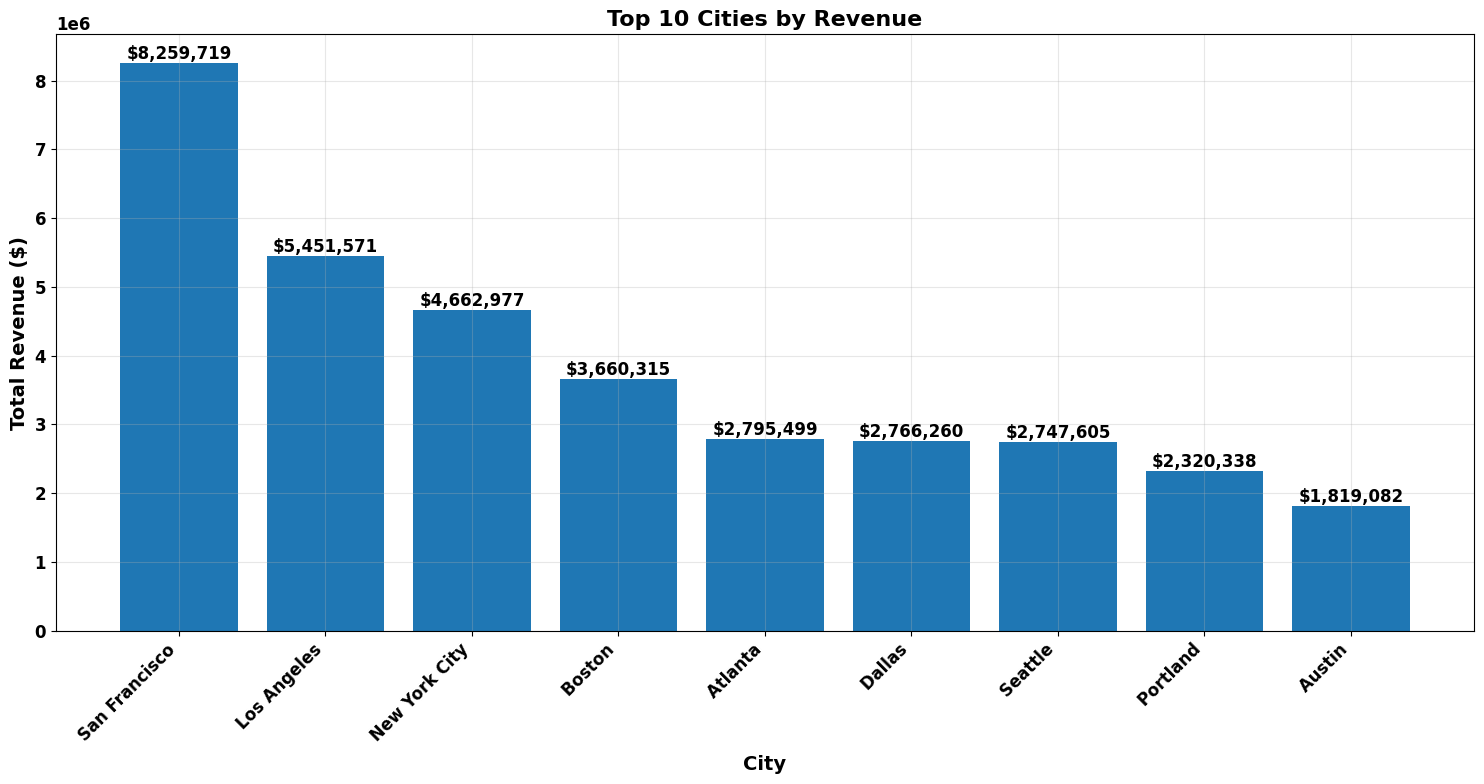

In [109]:
  # 1. Top 10 Cities by Revenue
plt.figure(figsize=(15, 8))
top_10_cities = city_summary.nlargest(10, 'Total Revenue')
plt.bar(range(len(top_10_cities)), top_10_cities['Total Revenue'])
plt.title('Top 10 Cities by Revenue')
plt.xlabel('City')
plt.ylabel('Total Revenue ($)')
plt.xticks(range(len(top_10_cities)), top_10_cities['City'], rotation=45, ha='right')
for i, v in enumerate(top_10_cities['Total Revenue']):
            plt.text(i, v, f'${v:,.0f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig(viz_dir / 'top_10_cities_revenue.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

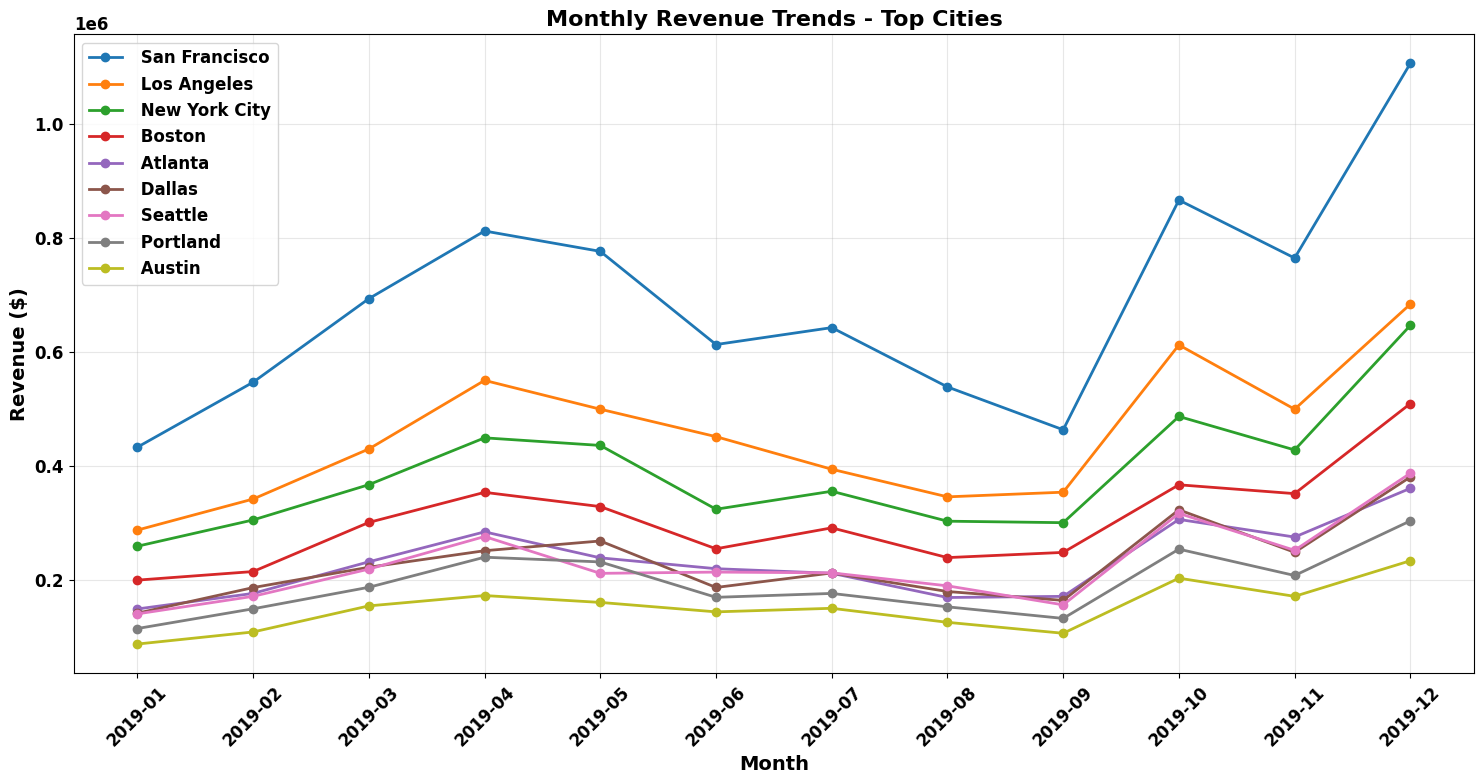

In [110]:
# 2. Monthly Revenue Trends for all Cities
plt.figure(figsize=(15, 8))
top_10_cities = city_summary.nlargest(10, 'Total Revenue')['City']
monthly_top_10 = monthly_city[monthly_city['City'].isin(top_10_cities)]
        
for city in top_10_cities:
    city_data = monthly_top_10[monthly_top_10['City'] == city]
    plt.plot(range(len(city_data)), city_data['Revenue'], 'o-', label=city, linewidth=2)
            
plt.title('Monthly Revenue Trends - Top Cities')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.xticks(range(len(monthly_top_10['Month'].unique())), 
                  monthly_top_10['Month'].unique(), rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(viz_dir / 'Top_cities_monthly_trend.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

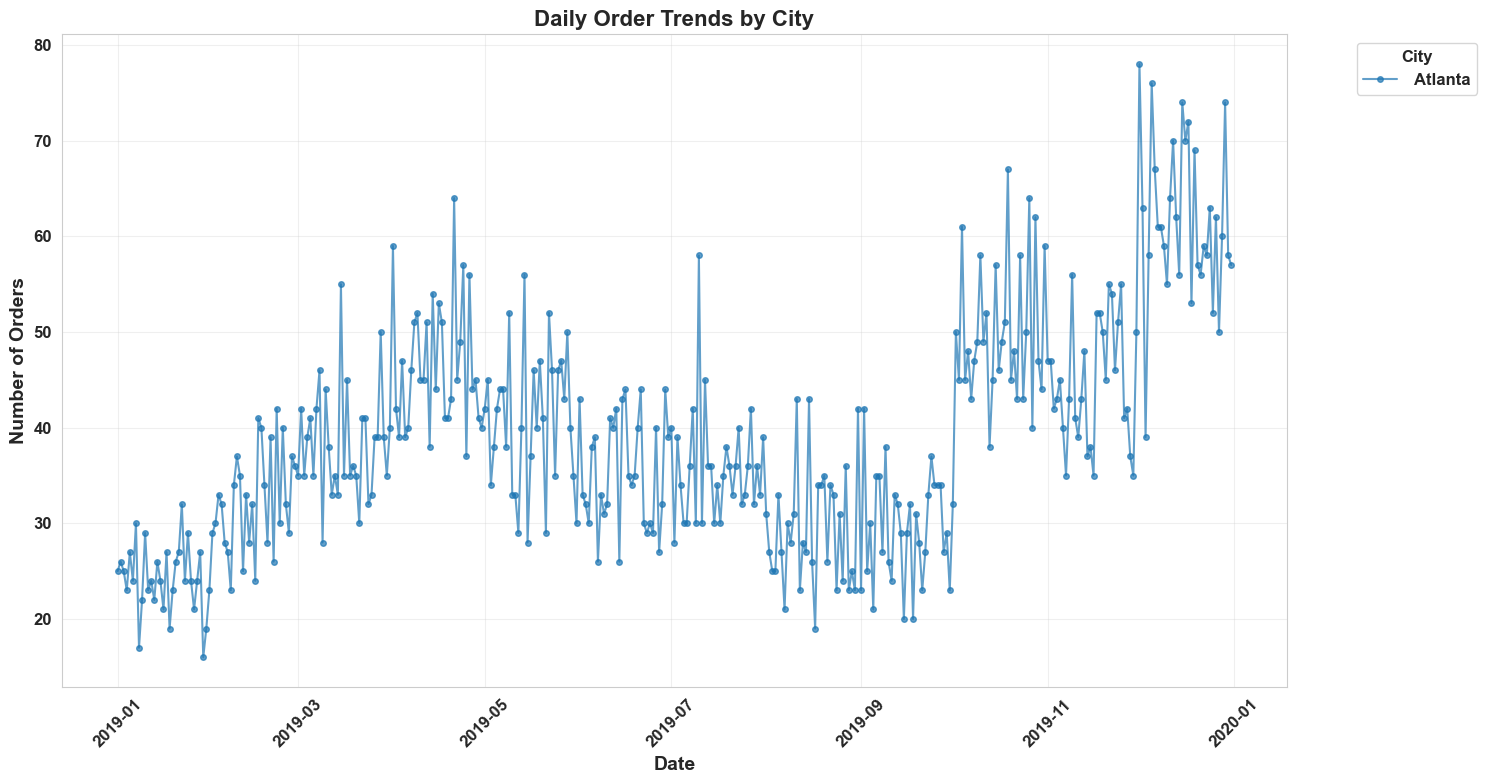

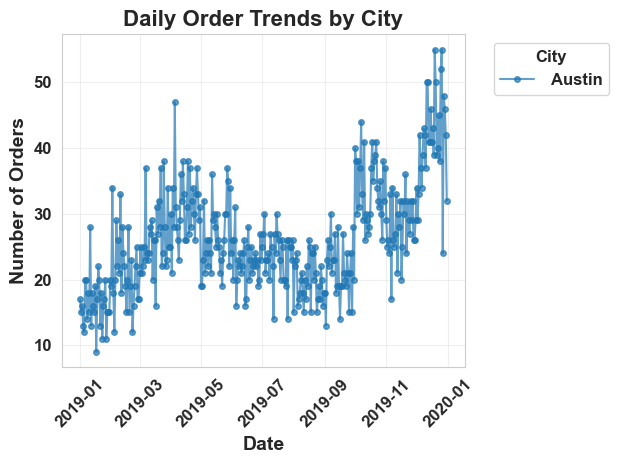

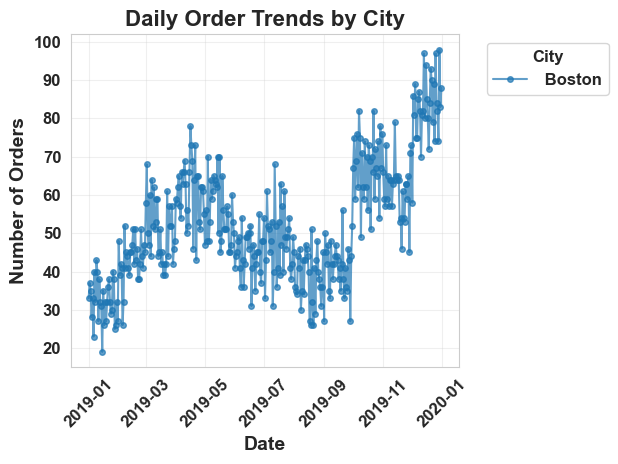

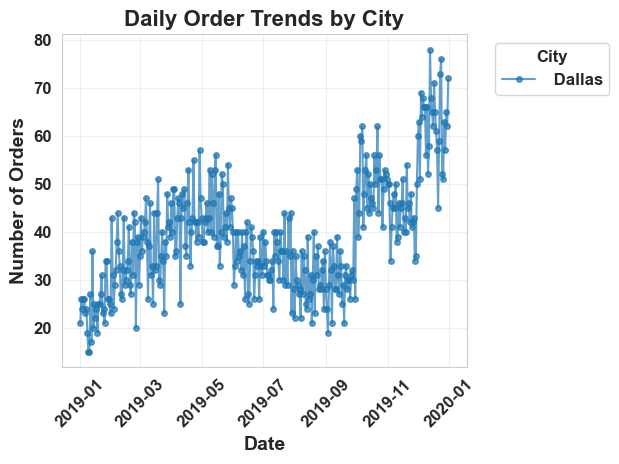

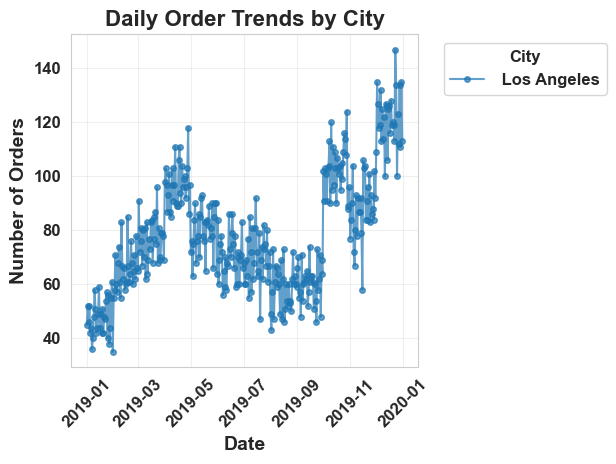

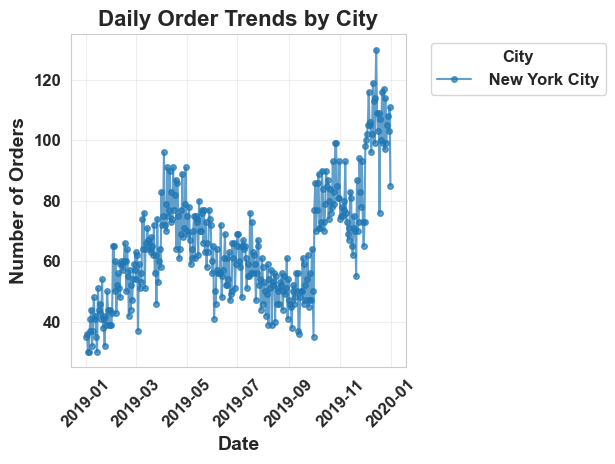

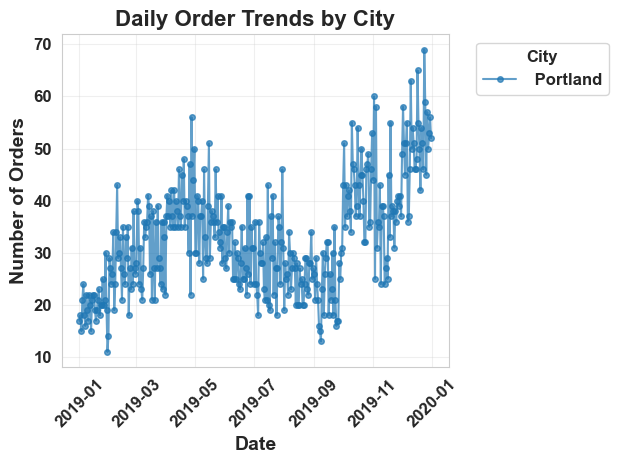

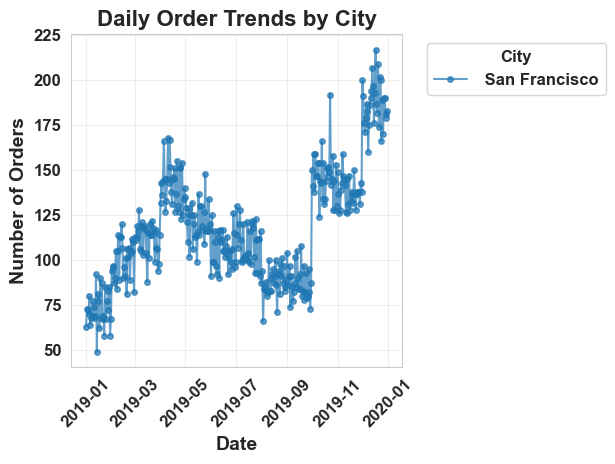

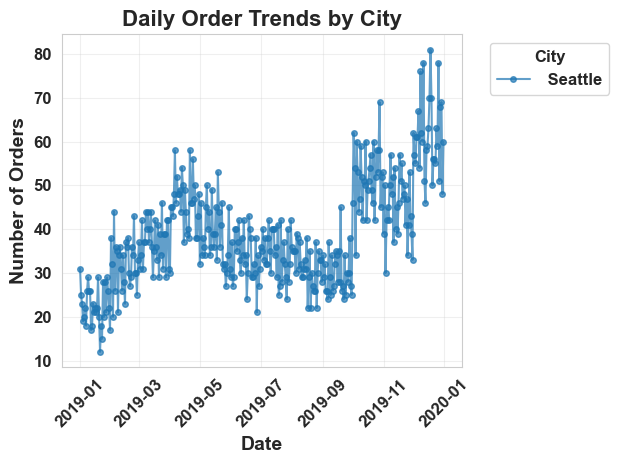

In [111]:
# Set Seaborn style
sns.set_style("whitegrid")
        
# 1. Line chart of daily orders by city
plt.figure(figsize=(15, 8))
for city in daily_orders['City'].unique():
    city_data = daily_orders[daily_orders['City'] == city]
    plt.plot(city_data['Date'], city_data['Number of Orders'], 
                    label=city, marker='o', markersize=4, alpha=0.7)
        
    plt.title('Daily Order Trends by City')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.xticks(rotation=45)
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / 'daily_orders_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
        


In [112]:
file_path = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\Consolidated2019Sales.csv')
df = pd.read_csv(file_path)
        
      
# Extract hour from OrderTime
df['Hour'] = df['OrderTime'].str.split(':').str[0].astype(int)

# Calculate total amount for each order
df['Total Amount'] = (df['Quantity'] * df['UnitPrice']).round(2)

# Calculate total orders per city to identify top 3
city_totals = df.groupby('City')['Order ID'].nunique().sort_values(ascending=False)
top_3_cities = city_totals.head(3).index.tolist()
        
        
# Filter data for top 3 cities
top_cities_data = df[df['City'].isin(top_3_cities)]
print(f"Top 3 cities by order volume: {', '.join(top_3_cities)}")
top_cities_data.dtypes




Top 3 cities by order volume:  San Francisco,  Los Angeles,  New York City


Order ID           int64
Product           object
Quantity           int64
UnitPrice        float64
OrderDate         object
OrderTime         object
Store Address     object
City              object
State Code        object
Pincode            int64
Hour               int64
Total Amount     float64
dtype: object

In [113]:
# Calculate hourly metrics for each city
hourly_data = top_cities_data.groupby(['City', 'Hour']).agg({
            'Order ID': 'nunique',
            'Total Amount': 'sum',
            'Quantity': 'sum'
        }).reset_index()
        
# Rename columns
hourly_data = hourly_data.rename(columns={
            'Order ID': 'Number of Orders',
            'Total Amount': 'Total Revenue',
            'Quantity': 'Total Items'
        })
        
# Add time ranges for better readability
hourly_data['Time Range'] = hourly_data['Hour'].apply(
            lambda x: f"{x:02d}:00 - {(x+1):02d}:00"
        )
        
# Set style parameters
plt.style.use('default')
plt.rcParams.update({
            'figure.figsize': (15, 8),
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'axes.grid': True,
            'grid.alpha': 0.3,
            'font.family': 'sans-serif',
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16
        })
        
# Create output directory
output_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\Visualizations\\TopCitiesHourly')
output_dir.mkdir(parents=True, exist_ok=True)
        

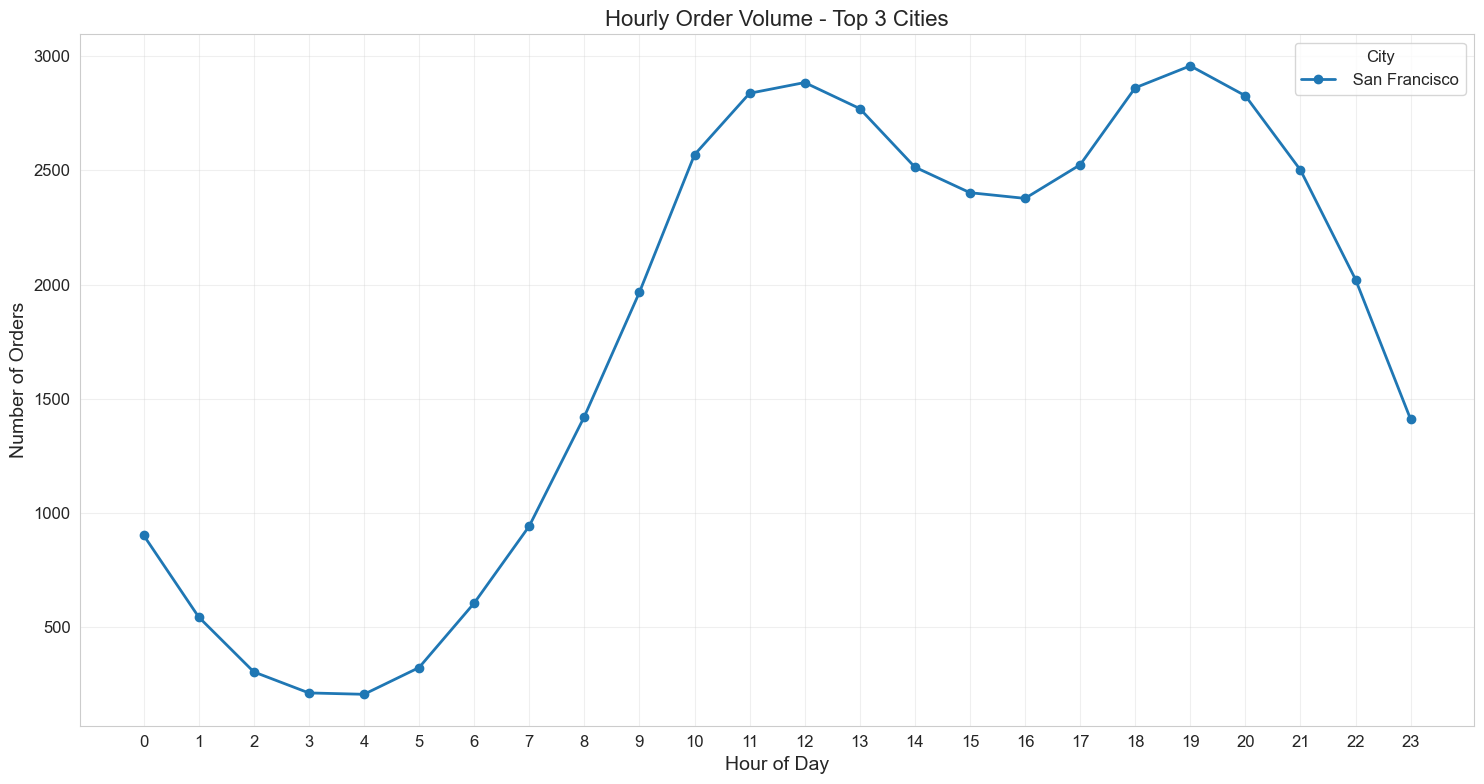

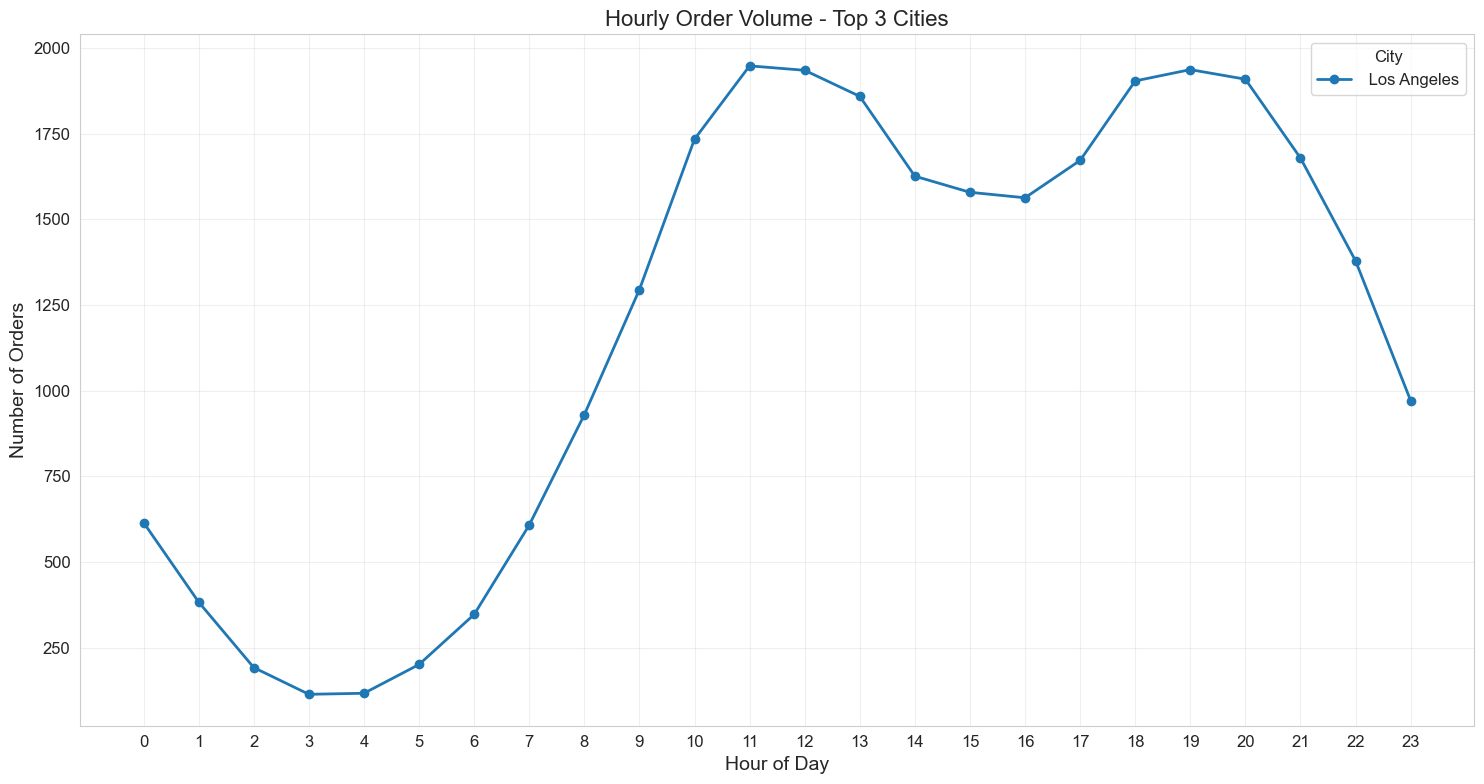

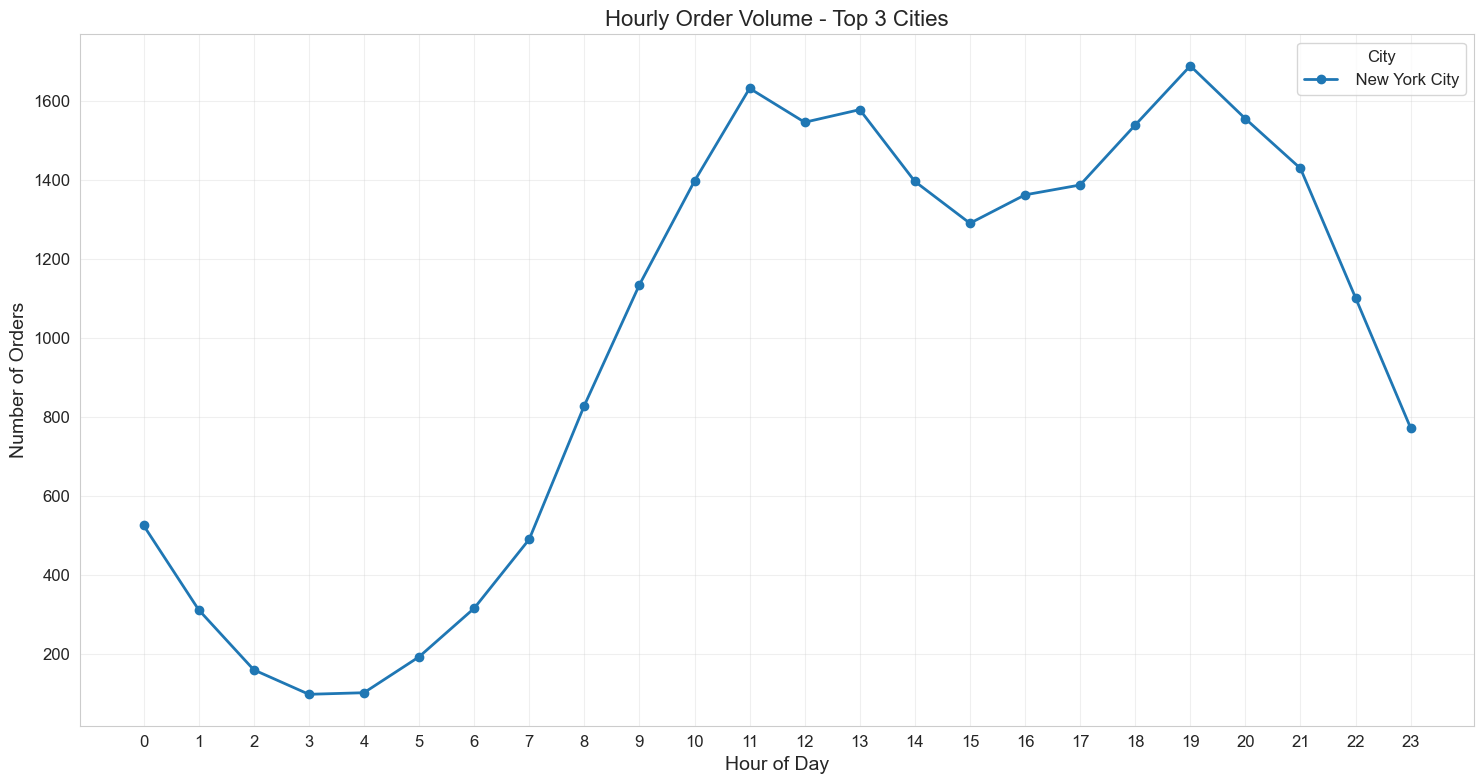

In [114]:
# Set Seaborn style
sns.set_style("whitegrid")
        
# 1. Combined hourly order volume
plt.figure(figsize=(15, 8))
for city in top_3_cities:
    city_data = hourly_data[hourly_data['City'] == city]
    plt.plot(city_data['Hour'], city_data['Number of Orders'], 
                    marker='o', label=city, linewidth=2)          
    plt.title('Hourly Order Volume - Top 3 Cities')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Orders')
    plt.legend(title='City')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(24))
    plt.tight_layout()
    plt.savefig(output_dir / 'top_cities_hourly_orders.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    


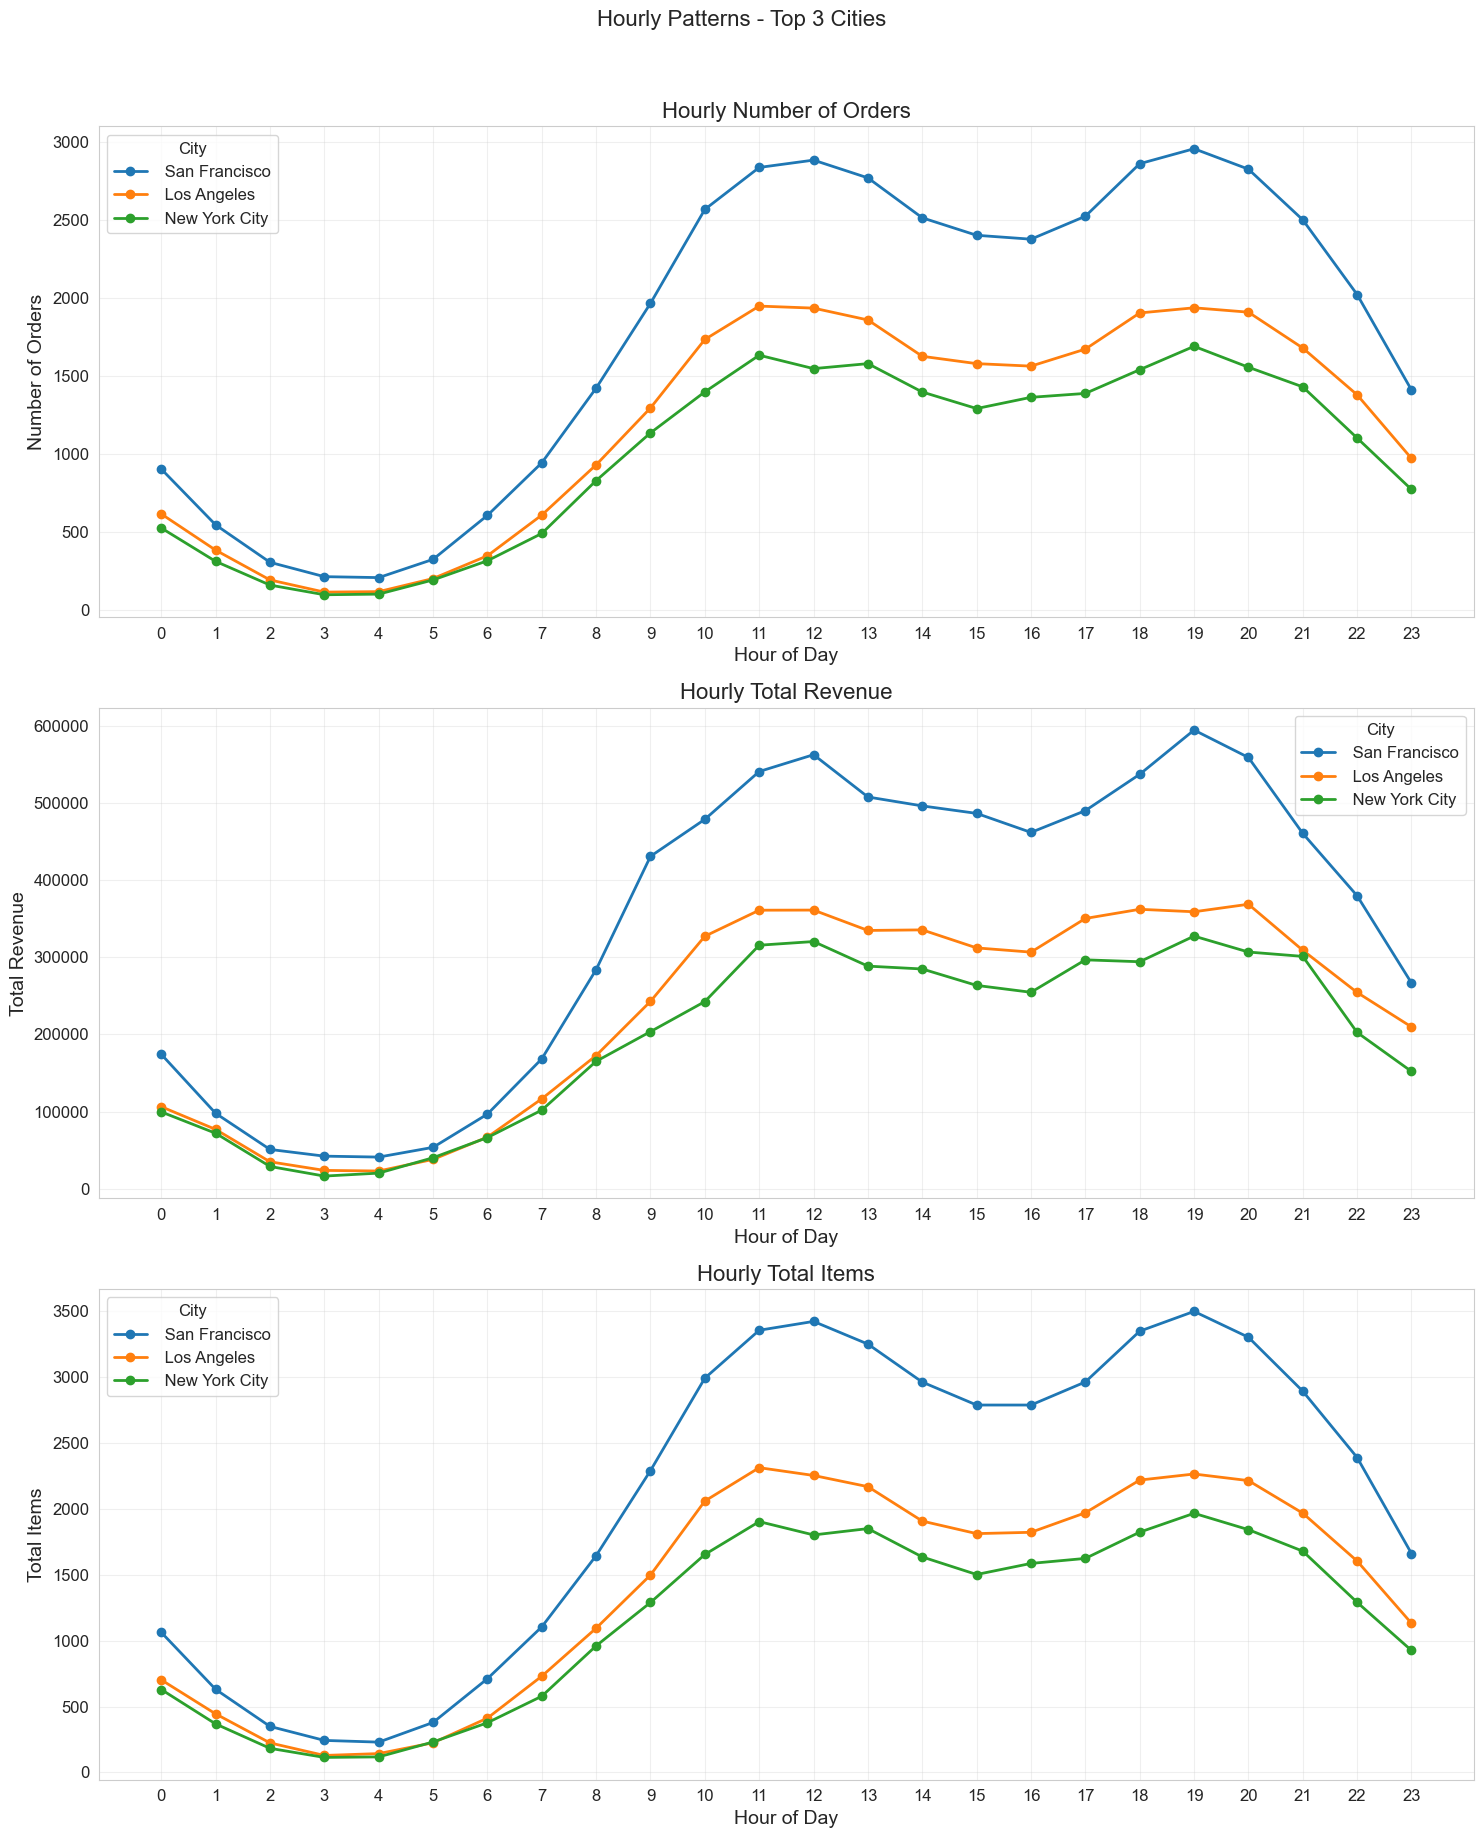

In [115]:
 # 2. Subplots for each metric
metrics = ['Number of Orders', 'Total Revenue', 'Total Items']
fig, axes = plt.subplots(3, 1, figsize=(15, 18))
fig.suptitle('Hourly Patterns - Top 3 Cities', y=1.02, fontsize=16)
        
for idx, (metric, ax) in enumerate(zip(metrics, axes)):
    for city in top_3_cities:
        city_data = hourly_data[hourly_data['City'] == city]
        ax.plot(city_data['Hour'], city_data[metric], 
                       marker='o', label=city, linewidth=2)
                
        ax.set_title(f'Hourly {metric}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel(metric)
        ax.legend(title='City')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(24))
        
plt.tight_layout()
plt.savefig(output_dir / 'top_cities_hourly_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
        
        

In [116]:
 # Save detailed statistics
stats_file = output_dir / 'top_cities_hourly_stats.csv'
hourly_data.to_csv(stats_file, index=False)